<a href="https://colab.research.google.com/github/julianmpratt/shockandtire/blob/main/Snowshoe_Julian_Pratt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=16pTJwYs0wA6eq7pwwNuhUVq0-EUYdTo8
To: /content/snowshoecsv.csv
100%|██████████| 11.8k/11.8k [00:00<00:00, 4.09MB/s]


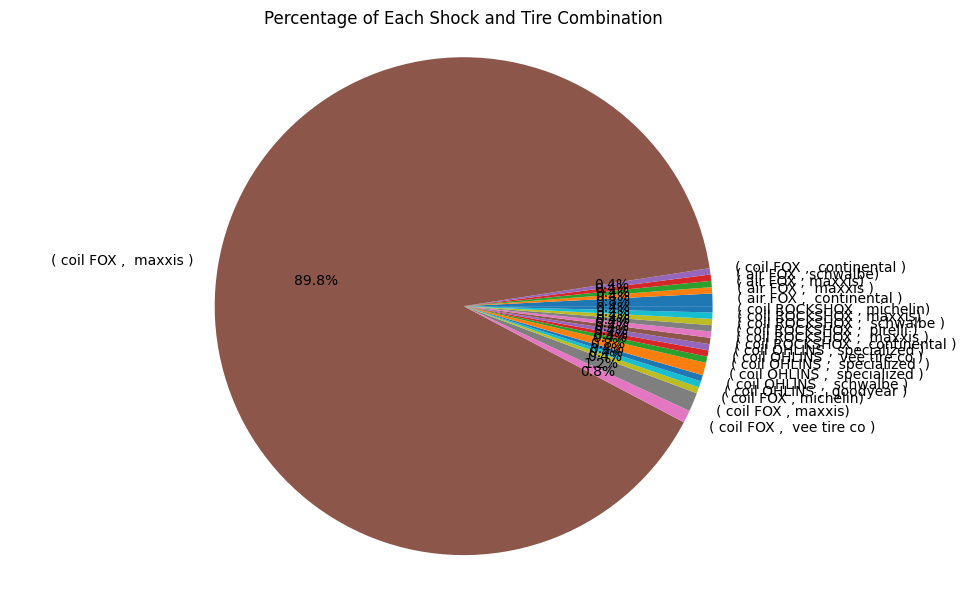

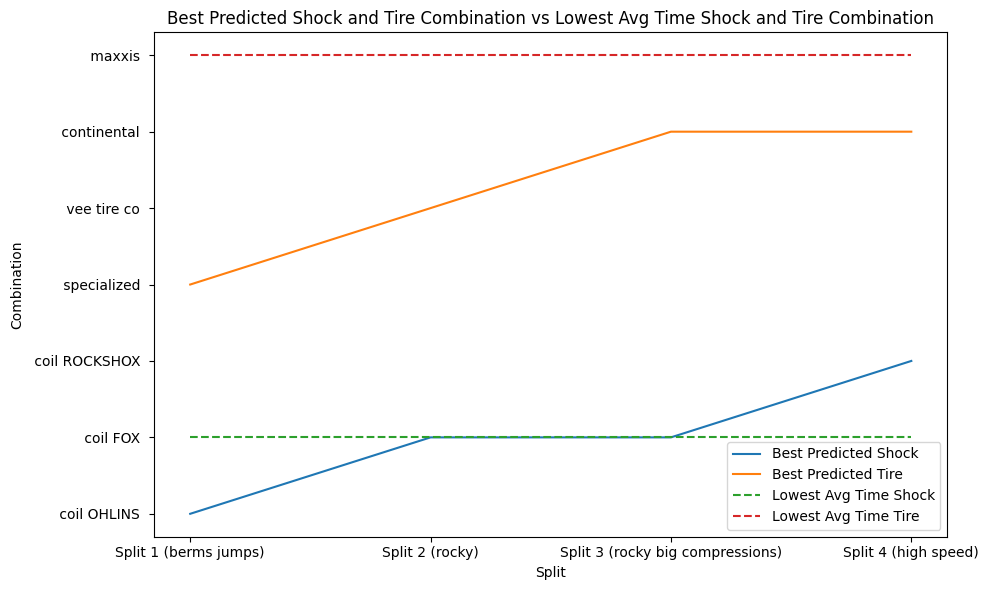

In [ ]:
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load the data
# Download the file from Google Drive
url = 'https://drive.google.com/uc?id=16pTJwYs0wA6eq7pwwNuhUVq0-EUYdTo8'
output = 'snowshoecsv.csv'
gdown.download(url, output, quiet=False)

# Load the data into a DataFrame
data = pd.read_csv(output)

# Remove leading and trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Drop unnamed columns
data.drop(data.columns[data.columns.str.contains('Unnamed', case=False)], axis=1, inplace=True)

# Preprocess the data
# Assuming 'Split 1' to 'Split 4' are the split time columns
splits = ['Split 1 (berms jumps)', 'Split 2 (rocky)', 'Split 3 (rocky big compressions)', 'Split 4 (high speed)']

# Handle missing values for 'Shock' column
imputer_shock = SimpleImputer(strategy='most_frequent')
data[['Shock']] = imputer_shock.fit_transform(data[['Shock']])

# Handle missing values for 'Tires' column
imputer_tires = SimpleImputer(strategy='most_frequent')
data[['Tires']] = imputer_tires.fit_transform(data[['Tires']])

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(data[['Shock', 'Tires']]).toarray()

# Create feature names for encoded columns
shock_categories = encoder.categories_[0]
tires_categories = encoder.categories_[1]
encoded_feature_names = list(shock_categories) + list(tires_categories)

# Concatenate the encoded columns with the original DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)
data_encoded = pd.concat([data, encoded_df], axis=1)

# Calculate the frequency of each shock and tire combination
combination_counts = data.groupby(['Shock', 'Tires']).size()

# Plot the frequency of each combination as a pie chart
plt.figure(figsize=(10, 6))
combination_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentage of Each Shock and Tire Combination')
plt.ylabel('')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

# Store the best shock and tire combination for each split
best_shocks = {}
best_tires = {}

# Train a predictive model for each split
for split in splits:
    # Define features and target
    X = data_encoded[encoded_feature_names]
    y = data_encoded[split]

    # Drop rows with missing values in both X and y
    data_dropna = pd.concat([X, y], axis=1).dropna()
    X = data_dropna[encoded_feature_names]
    y = data_dropna[split]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle missing values in the features
    imputer_features = SimpleImputer(strategy='mean')
    X_train = imputer_features.fit_transform(X_train)
    X_test = imputer_features.transform(X_test)

    # Train a Random Forest Regressor model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Find the shock and tire combination that resulted in the lowest time
    best_idx = model.predict(X_test).argmin()
    best_shocks[split] = data.loc[best_idx, 'Shock']
    best_tires[split] = data.loc[best_idx, 'Tires']

# Find the shock and tire combination with the lowest average time across all splits
lowest_avg_time_shock = data['Shock'].value_counts().idxmax()
lowest_avg_time_tire = data['Tires'].value_counts().idxmax()

# Plot the best shock and tire combination for each split
plt.figure(figsize=(10, 6))
plt.plot(splits, [best_shocks[split] for split in splits], label='Best Predicted Shock')
plt.plot(splits, [best_tires[split] for split in splits], label='Best Predicted Tire')
plt.plot(splits, [lowest_avg_time_shock] * len(splits), label='Lowest Avg Time Shock', linestyle='--')
plt.plot(splits, [lowest_avg_time_tire] * len(splits), label='Lowest Avg Time Tire', linestyle='--')
plt.xlabel('Split')
plt.ylabel('Combination')
plt.title('Best Predicted Shock and Tire Combination vs Lowest Avg Time Shock and Tire Combination')
plt.legend()
plt.tight_layout()
plt.show()
